In [4]:
# General
import sys
import os
import os.path as op
import glob
from copy import deepcopy
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import warnings
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import xarray
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
from scipy import signal
from scipy.io import loadmat
import h5py

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Neuro
import mne
from fooof import FOOOF, FOOOFGroup
from fooof.objs.utils import combine_fooofs
#import neurodsp

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
from formatting import *
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from unit_activity_and_hpc_theta import phase_locking as phlock
from time_cells import spike_sorting, spike_preproc, eeg_preproc, events_preproc, events_proc, spectral_analysis, time_bin_analysis
from phase_locking import eeg_preproc, spectral_analysis, unit_lfp_comparison

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

In [5]:
from phase_locking.unit_lfp_comparison import *

In [ ]:
def unit_to_lfp_phase_locking_osc2mask(unit,
                                       expmt='goldmine',
                                       game_states=['Encoding', 'Retrieval'],
                                       freqs=np.arange(1, 31),
                                       n_rois=6,
                                       n_perm=1000,
                                       alpha=0.05,
                                       data_dir='/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav',
                                       output_dir=None,
                                       save_output=True,
                                       overwrite=False,
                                       verbose=True):
    """Calculate unit's phase-locking to hippocampal oscillations when
    local oscillations are present versus absent.

    Parameters
    ----------
    unit : dict or series
        Contains the spike times vector and identifying info for a unit.
    freqs : array
        Frequencies at which spike-phase relations are analyzed.
    n_rois : int
        Number of meta-regions to assign for categorization.
    n_perm : int
        Number of permutations drawn to construst the null distribution.
        For each permutation, spike times are circ-shifted at random
        within each event, and phase-locking values at each frequency
        are recalculcated across events.
    alpha : float
        Defines the significance threshold for the phase-locking
        empirical p-value.
    data_dir : str
        Filepath to the location where saved inputs are stored.
    output_dir : str | None
        Filepath to the location where the output file is saved.
    save_output : bool
        Output is saved only if True.
    overwrite : bool
        If False and saved output already exists, it is simply returned
        at the top of this function. Otherwise phase-locking is
        calculated and, if save_output is True, any existing output file
        is overwritten.
    verbose : bool
        If True, some info is printed to the standard output.
        
    Returns
    -------
    pl_mrls : dataframe
        Each row corresponds to one unit -> LFPs from one microwire
        bundle.
    """
    timer = Timer()

    # Load the output file if it exists.
    output_b = '{}-{}-{}.pkl'.format(unit['subj_sess'], unit['chan'], unit['unit'])
    if output_dir is None:
        output_dir = op.join(data_dir, 'phase_locking', 'osc2mask')
    output_f = op.join(output_dir, output_b)
    if op.exists(output_f) and not overwrite:
        if verbose:
            print('Loading saved output: {}'.format(output_f))
        return dio.open_pickle(output_f)

    # Process the local LFP and all hippocampal ROIs.
    mont = spike_preproc.get_montage(unit['subj_sess'])
    roi_map = spike_preproc.roi_mapping(n=n_rois)
    hpc_rois = ['AH', 'MH', 'PH']
    lfp_hemrois = np.unique([hemroi for hemroi in mont.keys() if hemroi[1:] in hpc_rois])
    pl_mrls = []
    for lfp_hemroi in lfp_hemrois:
        # ------------------------------------
        # Data loading

        # Determine which regions we're looking at.
        lfp_roi_gen = roi_map[lfp_hemroi[1:]]
        if unit['roi_gen'] == 'HPC':
            if lfp_roi_gen == 'HPC':
                if unit['hemroi'] == lfp_hemroi:
                    edge = 'hpc-local'
                else:
                    edge = 'hpc-hpc'
            else:
                edge = 'hpc-ctx'
        else:
            if lfp_roi_gen != 'HPC':
                if unit['hemroi'] == lfp_hemroi:
                    edge = 'ctx-local'
                else:
                    edge = 'ctx-ctx'
            else:
                edge = 'ctx-hpc'
        same_hem = unit['hem'] == lfp_hemroi[0]
        same_roi_gen = unit['roi_gen'] == lfp_roi_gen

        # Load event_times.
        expmt = 'goldmine'
        game_states = ['Encoding']
        event_times = load_event_times(unit['subj_sess'],
                                       expmt=expmt,
                                       game_states=game_states,
                                       data_dir=data_dir)

        # Calculate spike times relative to the start of each event.
        event_time_spikes = load_event_time_spikes(event_times,
                                                   unit['spike_times'])

        # Load phase values for each event.
        basename_lfp = '{}-{}.pkl'.format(unit['subj_sess'], lfp_hemroi)
        phase = dio.open_pickle(op.join(data_dir, 'spectral', 'phase', basename_lfp))
        if (phase.buffer > 0) & (not phase.clip_buffer):
            phase = phase.loc[:, :, :, phase.buffer:phase.time.size-phase.buffer-1]
            phase.attrs['clip_buffer'] = True
        lfp_chans = [chan for chan in phase.chan.values if chan not in [unit['chan']]]
        if unit['chan'] in phase.chan:
            phase = phase.loc[{'chan': lfp_chans}]
        if not np.array_equal(phase.freq.values, freqs):
            phase = phase.loc[{'freq': [freq for freq in phase.freq.values if freq in freqs]}]
        if np.nanmax(phase.values) > np.pi:
            phase -= np.pi # convert values back to -π to π, with -π being the trough.

        # Load the P-episode mask for each event.
        roi_keys = ['unit', 'lfp']
        osc_mask = {}
        for key in roi_keys:
            hemroi = lfp_hemroi if key=='lfp' else unit['hemroi']
            basename = '{}-{}.pkl'.format(unit['subj_sess'], hemroi)
            osc_mask[key] = dio.open_pickle(op.join(data_dir, 'p_episode', basename))
            if (osc_mask[key].buffer > 0) & (not osc_mask[key].clip_buffer):
                osc_mask[key] = osc_mask[key].loc[:, :, :, osc_mask[key].buffer:osc_mask[key].time.size-osc_mask[key].buffer-1]
                osc_mask[key].attrs['clip_buffer'] = True
            if unit['chan'] in osc_mask[key].chan:
                osc_mask[key] = osc_mask[key].loc[{'chan': [chan for chan in osc_mask[key].chan.values
                                                            if chan not in [unit['chan']]]}]
            if not np.array_equal(osc_mask[key].freq.values, freqs):
                osc_mask[key] = osc_mask[key].loc[{'freq': [freq for freq in osc_mask[key].freq.values
                                                            if freq in freqs]}]
        osc_mask['lfp_and_unit'] = osc_mask['lfp'].copy(data=osc_mask['lfp'].values & np.any(osc_mask['unit'].values, axis=1)[:, None, :, :])
        osc_mask['lfp_not_unit'] = osc_mask['lfp'].copy(data=osc_mask['lfp'].values & ~np.any(osc_mask['unit'].values, axis=1)[:, None, :, :])
        
        mask_keys = ['lfp_and_unit', 'lfp_not_unit']
        for key in mask_keys:
            # Ensure that phase, oscillation mask, and spike_times are all in the same event order.
            assert np.array_equal(phase.event.values, osc_mask[key].event.values)
            assert np.array_equal(phase.event.values,
                                  np.array(event_time_spikes.apply(lambda x: (x['gameState'],
                                                                              x['trial']),
                                                                   axis=1).values))

            # Calculate P-episode at each frequency, across channels and events.
            peps = 100 * osc_mask[key].mean(dim=('event', 'chan', 'time')).values
            max_pep = np.nanmax(peps)
            max_pep_freq = np.nanargmax(peps)

            # ------------------------------------
            # Calculate real phase-locking

            # Get a masked array of spike phases, across events, during active
            # oscillations at each channel and frequency.
            event_dur = phase.time.size
            spike_phases = np.ma.concatenate(event_time_spikes.apply(
                lambda x: get_spike_phases(x['spike_times'],
                                           phase.values[x['event_idx'], :, :, :],
                                           mask=np.invert(osc_mask[key].values[x['event_idx'], :, :, :]),
                                           event_dur=event_dur,
                                           circshift=False),
                axis=1).tolist(), axis=-1) # chan x freq x spike

            # Calculate mean resultant lengths for each channel and frequency.
            mrls = np.nanmean([[circstats.circmoment(spike_phases[iChan, iFreq, :].compressed())[1]
                                for iFreq in range(spike_phases.shape[1])]
                               for iChan in range(spike_phases.shape[0])], axis=0).astype(np.float32) # (freq,)

            # Log how many spikes were counted per frequency,
            # taking the mean across channels.
            n_spikes_mask = np.nanmean([[spike_phases[iChan, iFreq, :].flatten().compressed().size
                                         for iFreq in range(spike_phases.shape[1])]
                                        for iChan in range(spike_phases.shape[0])], axis=0).astype(np.float32) # (freq,)

            # Get the preferred phase at each frequency, across channels.
            pref_phases = np.array([circstats.circmoment(spike_phases[:, iFreq, :].flatten().compressed())[0]
                                    for iFreq in range(spike_phases.shape[1])]).astype(np.float32) # (freq,)

            # ------------------------------------
            # Calculate null phase-locking
            mrls_null = []
            n_spikes_mask_null = []
            for iPerm in range(n_perm):
                # Get a masked array of spike phases, across events, during active
                # oscillations at each channel and frequency.
                _spike_phases_null = np.ma.concatenate(event_time_spikes.apply(
                    lambda x: get_spike_phases(x['spike_times'],
                                               phase[x['event_idx'], :, :, :],
                                               mask=np.invert(osc_mask[key][x['event_idx'], :, :, :]),
                                               event_dur=event_dur,
                                               circshift=True),
                    axis=1).tolist(), axis=-1) # chan x freq x spike

                # Calculate mean resultant lengths for each channel and frequency.
                _mrls_null = np.nanmean([[circstats.circmoment(_spike_phases_null[iChan, iFreq, :].compressed())[1]
                                          for iFreq in range(_spike_phases_null.shape[1])]
                                         for iChan in range(_spike_phases_null.shape[0])], axis=0).astype(np.float32)
                mrls_null.append(_mrls_null.tolist())

                _n_spikes_mask_null = np.nanmean([[_spike_phases_null[iChan, iFreq, :].flatten().compressed().size
                                                   for iFreq in range(_spike_phases_null.shape[1])]
                                                  for iChan in range(_spike_phases_null.shape[0])], axis=0).astype(np.float32)
                n_spikes_mask_null.append(_n_spikes_mask_null)

            mrls_null = np.array(mrls_null) # (perm, freq)
            n_spikes_mask_null = np.array(n_spikes_mask_null) # (perm, freq)

            # ------------------------------------
            # Statistics

            # Z-score MRLs against the null distribution,
            # and calculate empirical P-values.
            mean_mrls_null = np.nanmean(mrls_null, axis=0)
            std_mrls_null = np.nanstd(mrls_null, axis=0)
            z_mrls = (mrls - mean_mrls_null) / std_mrls_null # (freq,)
            z_mrls_null = (mrls_null - mean_mrls_null[None, :]) / std_mrls_null[None, :] # (perm, freq)
            max_z_mrl = np.nanmax(z_mrls)
            max_z_mrl_freq = freqs[np.nanargmax(z_mrls)]
            pval = (1 + np.nansum(np.nanmax(z_mrls_null, axis=1) >= max_z_mrl)) / (1 + n_perm)
            sig = pval < alpha

            mean_n_spikes_mask_null = np.nanmean(n_spikes_mask_null, axis=0)
            std_n_spikes_mask_null = np.nanstd(n_spikes_mask_null, axis=0)
            z_n_spikes_mask = (n_spikes_mask - mean_n_spikes_mask_null) / std_n_spikes_mask_null

            # ------------------------------------
            # Add results to dataframe.
            pl_mrls.append([unit['subj'],
                            unit['subj_sess'],
                            '{}-{}'.format(unit['chan'], unit['unit']),
                            unit['hemroi'],
                            unit['roi_gen'],
                            unit['n_spikes'],
                            unit['fr'],
                            lfp_hemroi,
                            lfp_roi_gen,
                            lfp_chans,
                            edge,
                            same_hem,
                            same_roi_gen,
                            key,
                            peps,
                            max_pep,
                            max_pep_freq,
                            n_spikes_mask,
                            n_spikes_mask_null,
                            mrls,
                            mrls_null,
                            pref_phases,
                            z_n_spikes_mask,
                            z_mrls,
                            max_z_mrl,
                            max_z_mrl_freq,
                            pval,
                            sig])

    # Create the output dataframe.
    cols = ['subj', 'subj_sess', 'unit', 'unit_hemroi', 'unit_roi_gen', 'n_spikes', 'fr',
            'lfp_hemroi', 'lfp_roi_gen', 'lfp_chans', 'edge', 'same_hem', 'same_roi_gen',
            'mask', 'peps', 'max_pep', 'max_pep_freq', 'n_spikes_mask', 'n_spikes_mask_null',
            'mrls', 'mrls_null', 'pref_phases',
            'z_n_spikes_mask', 'z_mrls', 'max_z_mrl', 'max_z_mrl_freq', 'pval', 'sig']
    pl_mrls = pd.DataFrame(pl_mrls, columns=cols)

    # Save the output.
    if save_output:
        dio.save_pickle(pl_mrls, output_f, verbose)
    
    if verbose:
        print('pl_mrls: {}'.format(pl_mrls.shape))
        print(timer)
        
    return pl_mrls

In [ ]:
def gold_view_dur(gold_id,
                  event_spikes,
                  timebin_dur=500):
    """Return gold view duration in ms."""
    giv = event_spikes.event_spikes.query("(gameState=='Encoding') & (gold_in_view==1)")
    dur = timebin_dur * np.sum(giv['gold_in_view_ids'].apply(lambda x: np.isin(gold_id, x)))
    return dur


def dig_attempts(gold_id,
                 event_spikes):
    """Return how many digs were attempted."""
    all_digs = event_spikes.event_spikes.query("(gameState=='Retrieval') & (dig_performed==1)")
    n_digs = np.sum(all_digs['dig_ids'].apply(lambda x: np.isin(gold_id, x)))
    return n_digs


def gold_dug(gold_id,
             event_spikes):
    """Return whether or not gold was dug."""
    all_digs = event_spikes.event_spikes.query("(gameState=='Retrieval') & (dig_success==1)")
    n_success = np.sum(all_digs['dig_ids'].apply(lambda x: np.isin(gold_id, x)))
    if n_success > 0:
        n_success = 1
    else:
        n_success = 0
    return n_success


for subj_sess in sessions:
    events = events_proc.load_events(subj_sess, verbose=0)
    evsp = time_bin_analysis.load_event_spikes(subj_sess, verbose=0)
    
    # Keep only nav intervals.
    game_states = ['Encoding', 'Retrieval']
    evsp.event_spikes = evsp.event_spikes.query("(gameState=={})".format(game_states))  

    # ---------------------------------------
    # Find all contiguous gold view events during Encoding.
    timebin_size = 500 # ms
    giv = evsp.event_spikes.query("(gameState=='Encoding') & (gold_in_view==True)")
    gold_views = []
    for _, gold in events.gold_spawned.iterrows():
        idx = giv.iloc[np.where(giv['gold_in_view_ids'].apply(lambda x: np.isin(gold['gold_id'], x)))[0]].index.tolist()
        if len(idx) > 0:
            gold_view_bounds = np.where(np.concatenate(([False], np.diff(idx) > 1)))[0]
            for iView, _idx in enumerate(np.split(idx, gold_view_bounds)):
                gold_views.append([gold['trial'],
                                   gold['gold_id'],
                                   iView+1,
                                   timebin_size * len(_idx),
                                   giv.loc[_idx, 'time_bin'].tolist(),
                                   dig_attempts(gold['gold_id'], evsp),
                                   gold_dug(gold['gold_id'], evsp),
                                   _idx])
    gold_views = pd.DataFrame(gold_views, columns=['trial', 'gold_id', 'view', 'dur',
                                                   'time_bins', 'digs', 'dig_success', 'idx'])

In [2]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join('/data7', 'goldmine', 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [227]:
# How many golds were spawned, viewed, and dug in each session?
n_trials = []
gold_spawned = []
min_gold = []
max_gold = []
mean_gold = []
gold_viewed = []
gold_dug = []
dig_acc = []
for subj_sess in sessions:
    events = events_proc.load_events(subj_sess, verbose=0)
    n_trials.append(events.gold_spawned['trial'].unique().size)
    gold_spawned.append(events.gold_spawned['gold_id'].unique().size)
    gold_per_trial = events.gold_spawned.groupby('trial').size()
    min_gold.append(np.min(gold_per_trial))
    max_gold.append(np.max(gold_per_trial))
    mean_gold.append(np.mean(gold_per_trial))
    gold_viewed.append(events.gold_events.query("(gameState=='Encoding') & (in_view==True)")['gold_id'].unique().size)
    gold_dug.append(len(events.dig_events.query("(dig_success==True)")))
    dig_acc.append(events.dig_events['dig_success'].mean())
    print('{}: {} trials {} gold spawned ({}-{}/trial, mean {:.1f}), {}/{} ({:.1%}) viewed, {:>2}/{} ({:.1%}) dug, {:.1%} digging accuracy'
          .format(subj_sess, n_trials[-1], gold_spawned[-1], min_gold[-1], max_gold[-1], mean_gold[-1],
                  gold_viewed[-1], gold_spawned[-1], gold_viewed[-1] / gold_spawned[-1],
                  gold_dug[-1], gold_viewed[-1], gold_dug[-1] / gold_viewed[-1], dig_acc[-1]))

print('', 'Across sessions', '-' * 15,
      'gold_spawned: mean = {:.1f} (range {}-{})'.format(np.mean(gold_spawned), np.min(gold_spawned), np.max(gold_spawned)),
      'gold_viewed: mean = {:.1f} (range {}-{})'.format(np.mean(gold_viewed), np.min(gold_viewed), np.max(gold_viewed)),
      'gold_dug: mean = {:.1f} (range {}-{})'.format(np.mean(gold_dug), np.min(gold_dug), np.max(gold_dug)),
      'dig_acc: mean = {:.1%} (range {:.1%}-{:.1%})'.format(np.mean(dig_acc), np.min(dig_acc), np.max(dig_acc)), sep='\n')

U518_ses0: 36 trials 40 gold spawned (1-2/trial, mean 1.1), 27/40 (67.5%) viewed, 13/27 (48.1%) dug, 34.2% digging accuracy
U518_ses1: 34 trials 58 gold spawned (1-4/trial, mean 1.7), 46/58 (79.3%) viewed, 32/46 (69.6%) dug, 56.1% digging accuracy
U521_ses0: 35 trials 39 gold spawned (1-2/trial, mean 1.1), 19/39 (48.7%) viewed,  9/19 (47.4%) dug, 25.7% digging accuracy
U526_ses0: 36 trials 59 gold spawned (1-3/trial, mean 1.6), 44/59 (74.6%) viewed, 32/44 (72.7%) dug, 71.1% digging accuracy
U527_ses0: 36 trials 71 gold spawned (1-3/trial, mean 2.0), 63/71 (88.7%) viewed, 46/63 (73.0%) dug, 63.9% digging accuracy
U530_ses0: 36 trials 38 gold spawned (1-2/trial, mean 1.1), 19/38 (50.0%) viewed, 10/19 (52.6%) dug, 55.6% digging accuracy
U530_ses1: 36 trials 48 gold spawned (1-2/trial, mean 1.3), 37/48 (77.1%) viewed, 20/37 (54.1%) dug, 48.8% digging accuracy
U532_ses0: 33 trials 65 gold spawned (1-4/trial, mean 2.0), 56/65 (86.2%) viewed, 44/56 (78.6%) dug, 41.5% digging accuracy
U536_ses

In [6]:
# Load spikes.
fr_thresh = 0.2
nspike_thresh = 0 # 400
n_rois = 6
expmt = 'goldmine'
game_states = ['Encoding', 'Retrieval']
spikes = unit_lfp_comparison.load_all_unit_spikes(fr_thresh=fr_thresh,
                                                  nspike_thresh=nspike_thresh,
                                                  n_rois=n_rois,
                                                  expmt=expmt,
                                                  game_states=game_states)

10 subjects, 12 sessions
spikes: (448, 10)
Ran in 30.6s


In [249]:
def _get_gold_views(gold_df,
                    events):
    """Return start, stop times for each gold view interval."""
    gold_df = gold_df.reset_index(drop=True)
    trial = gold_df.iloc[0]['trial']
    gold_id = gold_df.iloc[0]['gold_id']
    event_start, event_stop = (events.event_times.query("(trial=={}) & (gameState=='Encoding')".format(trial))
                                                 .iloc[0]['time_bins'][[0, -1]])
    
    giv = gold_df.query("(in_view==True)").index
    if len(giv) > 0:
        _gold_df = gold_df.loc[giv[0]:].copy()
    else:
        gold_views = pd.DataFrame([], columns=['subj', 'subj_sess', 'trial', 'gold_id', 'view',
                                               'digs', 'dig_success', 'start_time', 'stop_time', 'dur'])
        return gold_views

    _gold_df['view_change'] = [False] + list(_gold_df['in_view'][:-1].values != _gold_df['in_view'][1:].values)
    _gold_df.query("(view_change==True)")

    gv_idx = np.concatenate(([_gold_df.index.values[0]], _gold_df.query("(view_change==True)").index.values))
#     gv_idx[1::2] -= 1
    gv_times = gold_df.loc[gv_idx, 'time'].tolist()
    if len(gv_times) % 2 == 1:
        gv_times.append(event_stop)
    gold_views = pd.DataFrame(np.vstack((gv_times[::2], gv_times[1::2])).T,
                              columns=['start_time', 'stop_time'])
    gold_views -= event_start
    gold_views.insert(0, 'subj', events.subj_sess.split('_')[0])
    gold_views.insert(1, 'subj_sess', events.subj_sess)
    gold_views.insert(2, 'trial', trial)
    gold_views.insert(3, 'gold_id', gold_id)
    gold_views.insert(4, 'view', np.arange(len(gold_views))+1)
    gold_views.insert(5, 'digs', len(events.dig_events.query("(gold_id=='{}')".format(gold_id))))
    gold_views.insert(6, 'dig_success', len(events.dig_events.query("(gold_id=='{}') & (dig_success==True)".format(gold_id))) > 0)
    gold_views['dur'] = gold_views['stop_time'] - gold_views['start_time']
    return gold_views

In [292]:
# Save all gold view events for each session.
output_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events'
save_output = True
overwrite = False

# -----------------------
timer = Timer()

gold_views = []
for subj_sess in sessions:
    output_f = op.join(output_dir, '{}-gold_views.pkl'.format(subj_sess))
    if op.exists(output_f) and not overwrite:
        gold_views.append(dio.open_pickle(output_f))
        continue
    events = events_proc.load_events(subj_sess, verbose=False)
    gold_views.append(pd.concat([_get_gold_views(df, events)
                                 for _, df in events.gold_events.query("(gameState=='Encoding')")
                                                                .groupby(['trial', 'gold_id'])])
                        .reset_index(drop=True))
    if save_output:
        dio.save_pickle(gold_views[-1], output_f)
gold_views = pd.concat(gold_views).reset_index(drop=True)

print('gold_views: {}'.format(gold_views.shape))
print(timer)

gold_views: (663, 10)
Ran in 0.0s


In [283]:
# Save gold view masks for each session.
expmt = 'goldmine'
game_states = ['Encoding']
event_dur = 30000
data_dir='/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'
save_output = True
overwrite = False

# -----------------------
timer = Timer()

for subj_sess in sessions:
    # Load the output file if it exists.
    output_f = op.join(data_dir, 'events', '{}-gold_view_mask.pkl'.format(subj_sess))
    if op.exists(output_f) and not overwrite:
        gold_view_mask = dio.open_pickle(output_f)
        continue
    
    # Load event_times.
    event_times = load_event_times(subj_sess,
                                   expmt=expmt,
                                   game_states=game_states,
                                   data_dir=data_dir)
    
    # Load gold views.
    gold_views = dio.open_pickle(op.join(data_dir, 'events', '{}-gold_views.pkl'.format(subj_sess)))
    n_trials = event_times.query("(gameState=={})".format(game_states))['trial'].unique().size
    
    # Create masks of gold view times for golds that were later dug,
    # or not dug, respectively.
    trial_to_iTrial = {v:k for (k,v) in event_times.query("(gameState=={})".format(game_states))
                                                   .reset_index()['trial']
                                                   .to_dict().items()}
    gold_view_mask = {'dug': np.zeros([n_trials, event_dur], dtype=bool),
                      'not_dug': np.zeros([n_trials, event_dur], dtype=bool)}
    for key in ['dug', 'not_dug']:
        dig_success = True if (key=='dug') else False
        qry = "(dig_success=={})".format(dig_success)
        for (trial, df) in gold_views.query(qry).groupby('trial'):
            iTrial = trial_to_iTrial[trial]
            for (_, (start_time, stop_time)) in df[['start_time', 'stop_time']].iterrows():
                gold_view_mask[key][iTrial, start_time:stop_time] = 1

    if save_output:
        dio.save_pickle(gold_view_mask, output_f)
        
print(timer)

Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U518_ses0-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U518_ses1-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U521_ses0-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U526_ses0-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U527_ses0-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U530_ses0-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U530_ses1-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U532_ses0-gold_view_mask.pkl
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav/events/U536_ses0-gold_view_mask.pkl
S

In [293]:
# How many total golds were viewed,
# how many times was each gold viewed,
# and how long was each gold viewed,
# for golds that were dug vs. not dug,
# across subjects?
gold_view_agg = (gold_views
                 .groupby(['subj', 'subj_sess', 'gold_id', 'dig_success'])
                 .agg({'view': len,
                       'dur': np.sum})
                 .reset_index()
                 .groupby(['subj', 'subj_sess', 'dig_success'])
                 .agg({'gold_id': len,
                       'view': np.mean,
                       'dur': np.mean})
                 .groupby(['subj', 'dig_success'])
                 .agg({'gold_id': np.mean,
                       'view': np.mean,
                       'dur': np.mean})
                 .groupby(['dig_success'])
                 .agg({'gold_id': mean_sem,
                       'view': mean_sem,
                       'dur': mean_sem})
                 .rename(columns={'gold_id': 'golds_viewed',
                                  'view': 'views_per_gold',
                                  'dur': 'dur_per_gold'}))
gold_view_agg

,golds_viewed,views_per_gold,dur_per_gold
dig_success,,,
False,13.10 ± 0.90,1.34 ± 0.07,2879.04 ± 210.78
True,23.65 ± 4.18,1.56 ± 0.08,5579.37 ± 727.51


In [253]:
# How many total golds were viewed,
# how many times was each gold viewed,
# and how long was each gold viewed,
# for golds that were dug vs. not dug,
# across subjects?
gold_view_agg = (gold_views
                 .groupby(['subj', 'subj_sess', 'gold_id', 'dig_success'])
                 .agg({'view': len,
                       'dur': np.sum})
                 .reset_index()
                 .groupby(['subj', 'subj_sess', 'dig_success'])
                 .agg({'gold_id': len,
                       'view': np.median,
                       'dur': np.median})
                 .groupby(['subj', 'dig_success'])
                 .agg({'gold_id': np.median,
                       'view': np.median,
                       'dur': np.median})
                 .groupby(['dig_success'])
                 .agg({'gold_id': median_q,
                       'view': median_q,
                       'dur': median_q})
                 .rename(columns={'gold_id': 'golds_viewed',
                                  'view': 'views_per_gold',
                                  'dur': 'dur_per_gold'}))
gold_view_agg

,golds_viewed,views_per_gold,dur_per_gold
dig_success,,,
False,"12.75 (10.50, 14.38)","1.00 (1.00, 1.00)","2625.00 (2390.94, 3188.00)"
True,"19.50 (12.62, 32.00)","1.25 (1.00, 1.50)","3562.75 (3250.25, 4187.00)"


In [413]:
# Load event_times.
subj_sess = 'U530_ses1'
unit = spikes.query("(subj_sess=='{}')".format(subj_sess)).iloc[0]
data_dir='/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'
expmt = 'goldmine'
game_states = ['Encoding']
events = events_proc.load_events(subj_sess)
event_times = load_event_times(unit['subj_sess'],
                               expmt=expmt,
                               game_states=game_states,
                               data_dir=data_dir)

# Calculate spike times relative to the start of each event.
event_time_spikes = load_event_time_spikes(event_times,
                                           unit['spike_times'])

gold_views = dio.open_pickle(op.join(data_dir, 'events', '{}-gold_views.pkl'.format(subj_sess)))

Loading saved Events file


In [414]:
print(events)

------------------------------------
U530_ses1
36 trials completed, 36 good

48 gold spawned
43 gold viewed (90%)
20 gold dug (42%)
41 dig attempts (49% accuracy)

dataframe sizes:
	events: (76325, 8)
	event_times: (216, 10)
	positions: (47745, 15)
	base_events: (9548, 7)
	gold_events: (11665, 8)
	gold_spawned: (48, 8)
	dig_events: (41, 8)
	events_behav: (6210, 20)



In [415]:
gold_view_spikes = pd.merge(gold_views.query("(subj_sess=='{}')".format(subj_sess)),
                            event_time_spikes[['trial', 'spike_times']],
                            how='left',
                            on='trial').reset_index(drop=True)
gold_view_spikes.head()

,subj,subj_sess,trial,gold_id,view,digs,dig_success,start_time,stop_time,dur,spike_times
0,U530,U530_ses1,1,gold0001,1,1,False,12882,17133,4251,"[164, 213, 422, 503, 764, 777, 1475, 1627, 172..."
1,U530,U530_ses1,3,gold0003,1,1,True,10399,14399,4000,"[129, 137, 531, 725, 732, 863, 1774, 2033, 224..."
2,U530,U530_ses1,4,gold0005,1,0,False,28866,29115,249,"[264, 522, 941, 1080, 1130, 1528, 1931, 2113, ..."
3,U530,U530_ses1,4,gold0005,2,0,False,29366,30000,634,"[264, 522, 941, 1080, 1130, 1528, 1931, 2113, ..."
4,U530,U530_ses1,5,gold0007,1,1,True,11150,11401,251,"[270, 382, 601, 809, 1215, 1413, 2154, 2269, 2..."


In [416]:
print(subj_sess)

(gold_view_spikes
 .groupby(['dig_success', 'gold_id'])
 .agg({'view': len,
       'dur': np.sum})
 .reset_index()
 .groupby(['dig_success'])
 .agg({'gold_id': len,
       'view': [mean_sem, median_q],
       'dur': [mean_sem, median_q]}))

U530_ses1


gold_id         view                                  dur  \
                len     mean_sem           median_q          mean_sem   
dig_success                                                             
False            18  1.17 ± 0.09  1.00 (1.00, 1.00)  2830.56 ± 338.05   
True             19  1.32 ± 0.11  1.00 (1.00, 2.00)  3180.79 ± 302.32   

                                         
                               median_q  
dig_success                              
False        2625.50 (1750.00, 3686.75)  
True         3250.00 (2001.00, 4250.00)

In [459]:
# unit_to_lfp_phase_locking_gold_view
subj_sess = 'U527_ses0'
unit = spikes.query("(subj_sess=='{}')".format(subj_sess)).iloc[0]
freqs=np.arange(1, 31)
n_rois=6
min_spikes = 20
n_samp_iter=10
n_perm=1000
alpha=0.05
data_dir='/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'
output_dir=None
save_output=True
overwrite=False
verbose=True
                                        
# ----------------------------------
timer = Timer()

# Load the output file if it exists.
output_b = '{}-{}-{}.pkl'.format(unit['subj_sess'], unit['chan'], unit['unit'])
if output_dir is None:
    output_dir = op.join(data_dir, 'phase_locking', 'gold_view')
output_f = op.join(output_dir, output_b)
if op.exists(output_f) and not overwrite:
    if verbose:
        print('Loading saved output: {}'.format(output_f))
    pl_mrls = dio.open_pickle(output_f)
    raise AssertionError('Output already saved: {}'.format(output_f))

# Hard-coded params.
expmt = 'goldmine'
game_states = ['Encoding']
gold_keys = ['dug', 'not_dug']

# Process the local LFP and all hippocampal ROIs.
mont = spike_preproc.get_montage(unit['subj_sess'])
roi_map = spike_preproc.roi_mapping(n=n_rois)
hpc_rois = ['AH', 'MH', 'PH']
lfp_hemrois = np.unique([unit['hemroi']] + [hemroi for hemroi in mont.keys()
                                            if np.all((np.isin(hemroi[1:], hpc_rois),
                                                       hemroi[0]==unit['hemroi'][0]))])
pl_mrls = []
for lfp_hemroi in lfp_hemrois:
    # ------------------------------------
    # Data loading

    # Determine which regions we're looking at.
    lfp_roi_gen = roi_map[lfp_hemroi[1:]]
    if unit['roi_gen'] == 'HPC':
        if lfp_roi_gen == 'HPC':
            if unit['hemroi'] == lfp_hemroi:
                edge = 'hpc-local'
            else:
                edge = 'hpc-hpc'
        else:
            edge = 'hpc-ctx'
    else:
        if lfp_roi_gen != 'HPC':
            if unit['hemroi'] == lfp_hemroi:
                edge = 'ctx-local'
            else:
                edge = 'ctx-ctx'
        else:
            edge = 'ctx-hpc'
    same_hem = unit['hem'] == lfp_hemroi[0]
    same_roi_gen = unit['roi_gen'] == lfp_roi_gen

    # Load event_times.
    event_times = load_event_times(unit['subj_sess'],
                                   expmt=expmt,
                                   game_states=game_states,
                                   data_dir=data_dir)

    # Calculate spike times relative to the start of each event.
    event_time_spikes = load_event_time_spikes(event_times,
                                               unit['spike_times'])

    # Load phase values for each event.
    basename_lfp = '{}-{}.pkl'.format(unit['subj_sess'], lfp_hemroi)
    phase = dio.open_pickle(op.join(data_dir, 'spectral', 'phase', basename_lfp))
    if (phase.buffer > 0) & (not phase.clip_buffer):
        phase = phase.loc[:, :, :, phase.buffer:phase.time.size-phase.buffer-1]
        phase.attrs['clip_buffer'] = True
    lfp_chans = [chan for chan in phase.chan.values if chan not in [unit['chan']]]
    if unit['chan'] in phase.chan:
        phase = phase.loc[{'chan': lfp_chans}]
    if not np.array_equal(phase.freq.values, freqs):
        phase = phase.loc[{'freq': [freq for freq in phase.freq.values if freq in freqs]}]
    if np.nanmax(phase.values) > np.pi:
        phase -= np.pi  # convert values back to -π to π, with -π being the trough

    # Load the P-episode mask for each event.
    osc_mask = dio.open_pickle(op.join(data_dir, 'p_episode', basename_lfp))
    if (osc_mask.buffer > 0) & (not osc_mask.clip_buffer):
        osc_mask = osc_mask.loc[:, :, :, osc_mask.buffer:osc_mask.time.size-osc_mask.buffer-1]
        osc_mask.attrs['clip_buffer'] = True
    if unit['chan'] in osc_mask.chan:
        osc_mask = osc_mask.loc[{'chan': [chan for chan in osc_mask.chan.values
                                          if chan not in [unit['chan']]]}]
    if not np.array_equal(osc_mask.freq.values, freqs):
        osc_mask = osc_mask.loc[{'freq': [freq for freq in osc_mask.freq.values
                                          if freq in freqs]}]
    osc_mask = osc_mask.sel(gameState='Encoding')  # [trial, chan, freq, time]

    # Load the gold-view mask for each event.        
    basename = '{}-gold_view_mask.pkl'.format(unit['subj_sess'])
    gold_mask = dio.open_pickle(op.join(data_dir, 'events', basename))  # [gold_key][trial, time]

    # Combine gold view and oscillatory masks.
#     osc_gold_mask = {key: (gold_mask[key][:, None, None, :] & osc_mask.values)
#                      for key in gold_keys}  # [gold_key][trial, chan, freq, time]
    osc_gold_mask = {key: gold_mask[key][:, None, None, :]
                     for key in gold_keys}  # [gold_key][trial, chan, freq, time]

    # Calculate P-episode at each frequency, across channels and events.
    peps = {key: 100 * np.nanmean(osc_gold_mask[key], axis=(0, 1, 3))
            for key in gold_keys}
    max_pep = {key: np.nanmax(peps[key]) for key in gold_keys}
    max_pep_freq = {key: np.nanargmax(peps[key]) for key in gold_keys}

    # Get gold view spike phases at each freq. across events,
    # for later dug and not dug golds.
    event_dur = phase.time.size
    spike_phases = {
        key: np.ma.concatenate(
            event_time_spikes.apply(
                lambda x: get_spike_phases(x['spike_times'],
                                           phase.values[x['event_idx'], :, :, :],
                                           mask=np.invert(osc_gold_mask[key][x['event_idx'], :, :, :]),
                                           event_dur=event_dur,
                                           circshift=False),
                axis=1).tolist(), axis=-1)
        for key in gold_keys}  # [gold_key][chan, freq, spike]
    
    # Find the minimum number of spikes at each channel and frequency,
    # between dug and not dug golds.
    n_freq = phase.freq.size
    n_chan = phase.chan.size
    samp_spikes = np.nanmin([[[spike_phases[key][iChan, iFreq, :].compressed().size
                               for iFreq in range(n_freq)]
                              for iChan in range(n_chan)]
                             for key in gold_keys], axis=0)  # [chan, freq]
    
    # Calculate mean resultant lengths for each channel and frequency.
    mrls = {key: np.empty([n_chan, n_freq], dtype=np.float32)
            for key in gold_keys}
    for key in gold_keys:
        for iChan in range(n_chan):
            _mrls = []
            for iFreq in range(n_freq):
                phi = spike_phases[key][iChan, iFreq, :].compressed()
                if samp_spikes[iChan, iFreq] < min_spikes:
                    mrls[key][iChan, iFreq] = np.nan
                elif phi.size == samp_spikes[iChan, iFreq]:
                    mrls[key][iChan, iFreq] = circstats.circmoment(phi)[1]
                else:
                    mrls[key][iChan, iFreq] = np.nanmean(
                        [circstats.circmoment(np.random.choice(phi,
                                                               size=samp_spikes[iChan, iFreq],
                                                               replace=False))[1]
                         for _ in range(n_samp_iter)]
                    )
    mrls = {key: np.nanmean(mrls[key], axis=0)
            for key in gold_keys}  # [gold_key][freq]
    
    break
    
print(timer)

Ran in 7.0s


In [460]:
lfp_hemrois, unit

(array(['LMH'], dtype='<U3'),
 subj                                                        U527
 subj_sess                                              U527_ses0
 chan                                                           9
 unit                                                           2
 hemroi                                                       LMH
 hem                                                            L
 roi_gen                                                      HPC
 n_spikes                                                    5088
 fr                                                       2.35556
 spike_times    [1306, 4844, 6573, 6594, 6879, 7408, 7491, 110...
 Name: 126, dtype: object)

In [461]:
print(np.array([[spike_phases['dug'][iChan, iFreq, :].compressed().size
                        for iFreq in range(n_freq)]
                       for iChan in range(n_chan)]), end='\n'*2)

print(np.array([[spike_phases['not_dug'][iChan, iFreq, :].compressed().size
                        for iFreq in range(n_freq)]
                       for iChan in range(n_chan)]), end='\n'*2)

print(samp_spikes, end='\n'*2)

[[367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367
  367 367 367 367 367 367 367 367 367 367 367 367]
 [367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367
  367 367 367 367 367 367 367 367 367 367 367 367]
 [367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367
  367 367 367 367 367 367 367 367 367 367 367 367]
 [367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367
  367 367 367 367 367 367 367 367 367 367 367 367]
 [367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367
  367 367 367 367 367 367 367 367 367 367 367 367]
 [367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367
  367 367 367 367 367 367 367 367 367 367 367 367]
 [367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367 367
  367 367 367 367 367 367 367 367 367 367 367 367]]

[[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
  109 109 109 109 109 109 109 109 109 109 109 109

In [454]:
vals = np.array(['{:.2f}'.format(x*100)
                 for x in np.mean(osc_mask.values, axis=(0, 1, 3))])
print('osc_mask %', '-' * len('osc_mask %'),
      vals[:10], vals[10:20], vals[20:],
      sep='\n')

osc_mask %
----------
['0.28' '5.26' '8.40' '9.49' '9.03' '7.46' '6.23' '5.67' '5.19' '4.64']
['4.27' '4.26' '4.27' '4.29' '4.25' '4.37' '4.46' '4.47' '4.34' '4.19']
['3.99' '3.71' '3.48' '3.30' '3.06' '2.80' '2.51' '2.27' '2.04' '1.80']


In [455]:
print('gold view %', '-' * len('gold view %'), sep='\n')
for key in gold_keys:
    print('{}: {:.2%}'.format(key, np.mean(gold_mask[key])))

gold view %
-----------
dug: 14.25%
not_dug: 3.41%


In [456]:
print('osc_gold_mask %', '-' * len('osc_gold_mask %'), sep='\n', end='\n'*2)
for key in gold_keys:
    vals = np.array(['{:.2f}'.format(x) for x in peps[key]])
    print(key, '-' * len(key),
          vals[:10], vals[10:20], vals[20:],
          sep='\n', end='\n'*2)

osc_gold_mask %
---------------

dug
---
['14.25']
[]
[]

not_dug
-------
['3.41']
[]
[]



In [462]:
print('n_spikes | osc, gold in view', '-' * len('n_spikes | osc, gold in view'),
      sep='\n', end='\n'*2)
for key in gold_keys:
    vals = np.nanmean([[spike_phases[key][iChan, iFreq, :].compressed().size
                        for iFreq in range(n_freq)]
                       for iChan in range(n_chan)], axis=0)
    vals = np.array(['{:>2.0f}'.format(x) for x in vals])
    print('gold {}'.format(key.replace('_', ' ')), '-' * len('gold {}'.format(key)),
          vals[:10], vals[10:20], vals[20:],
          sep='\n', end='\n'*2)
    
vals = np.array(['{:>2.0f}'.format(x) for x in np.nanmean(samp_spikes, axis=0)])
print('min(dug, not dug)', '-' * len('min(dug, not dug)'),
      vals[:10], vals[10:20], vals[20:],
      sep='\n', end='\n'*2)

n_spikes | osc, gold in view
----------------------------

gold dug
--------
['367' '367' '367' '367' '367' '367' '367' '367' '367' '367']
['367' '367' '367' '367' '367' '367' '367' '367' '367' '367']
['367' '367' '367' '367' '367' '367' '367' '367' '367' '367']

gold not dug
------------
['109' '109' '109' '109' '109' '109' '109' '109' '109' '109']
['109' '109' '109' '109' '109' '109' '109' '109' '109' '109']
['109' '109' '109' '109' '109' '109' '109' '109' '109' '109']

min(dug, not dug)
-----------------
['109' '109' '109' '109' '109' '109' '109' '109' '109' '109']
['109' '109' '109' '109' '109' '109' '109' '109' '109' '109']
['109' '109' '109' '109' '109' '109' '109' '109' '109' '109']



In [463]:
vals = np.array(['{:.2f}'.format(x) for x in mrls['dug'] - mrls['not_dug']])
print('MRL (dug - not_dug)', '-' * len('MRL (dug - not_dug)'),
      vals[:10], vals[10:20], vals[20:],
      sep='\n', end='\n'*2)

MRL (dug - not_dug)
-------------------
['-0.03' '0.05' '0.07' '0.07' '0.02' '0.01' '0.00' '0.03' '0.02' '0.02']
['0.04' '0.02' '0.02' '0.02' '0.01' '0.01' '-0.01' '-0.01' '-0.02' '-0.02']
['-0.02' '-0.02' '-0.03' '-0.01' '-0.00' '-0.01' '-0.01' '-0.01' '0.01'
 '0.00']



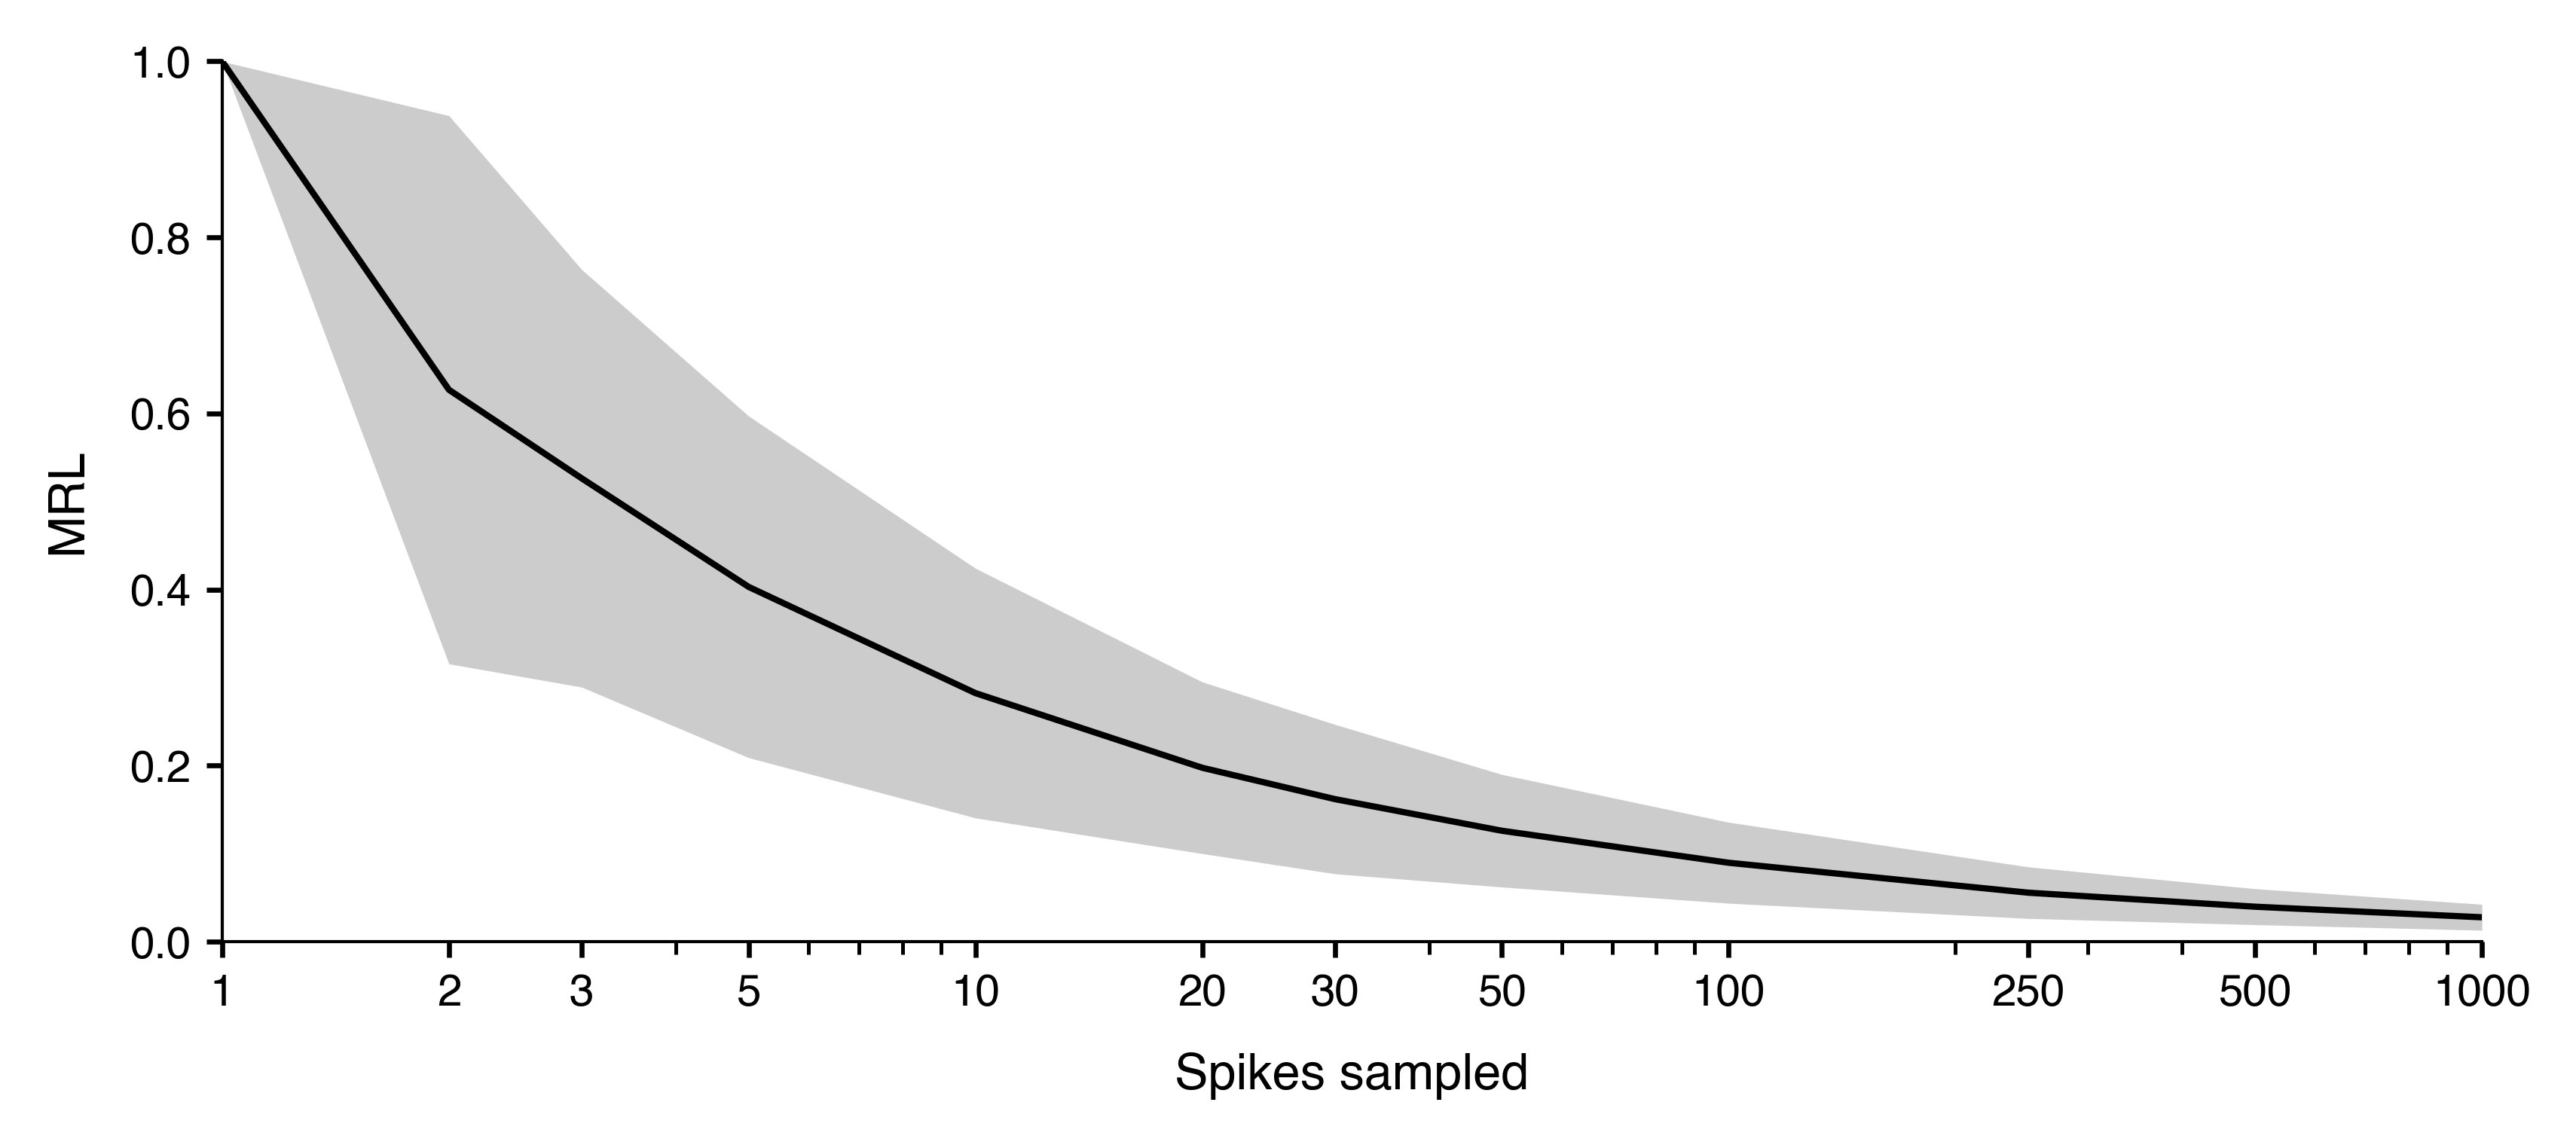

In [149]:
sizes = [1, 2, 3, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
mrls = np.array([[circstats.circmoment(np.random.uniform(-np.pi, np.pi, size))[1]
                  for size in sizes]
                 for ii in range(1000)])  # [iter, size]
plt.close()
fig, ax = plt.subplots(1, 1)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_means = np.nanmean(mrls, axis=0)
_stds = np.nanstd(mrls, axis=0)
xvals = sizes
_ax.fill_between(xvals, _means + _stds, _means - _stds, lw=0, color='k', alpha=0.2)
_ax.plot(xvals, _means, lw=1, color='k')
_ax.set_xscale('log')
_ax.set_xlim([1, 1000])
_ax.set_xticks(xvals)
_ax.set_xticklabels(xvals)
_ax.set_xlabel('Spikes sampled')
_ax.set_ylim([0, 1])
_ax.set_yticks(np.linspace(0, 1, 6))
_ax.set_ylabel('MRL')

fig.show()

noise_n: [1, 2, 3, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
signal_mult: 2
signal_prop: 1
n_samp_iter = 1
n_perm: 1000
Ran in 4.0s


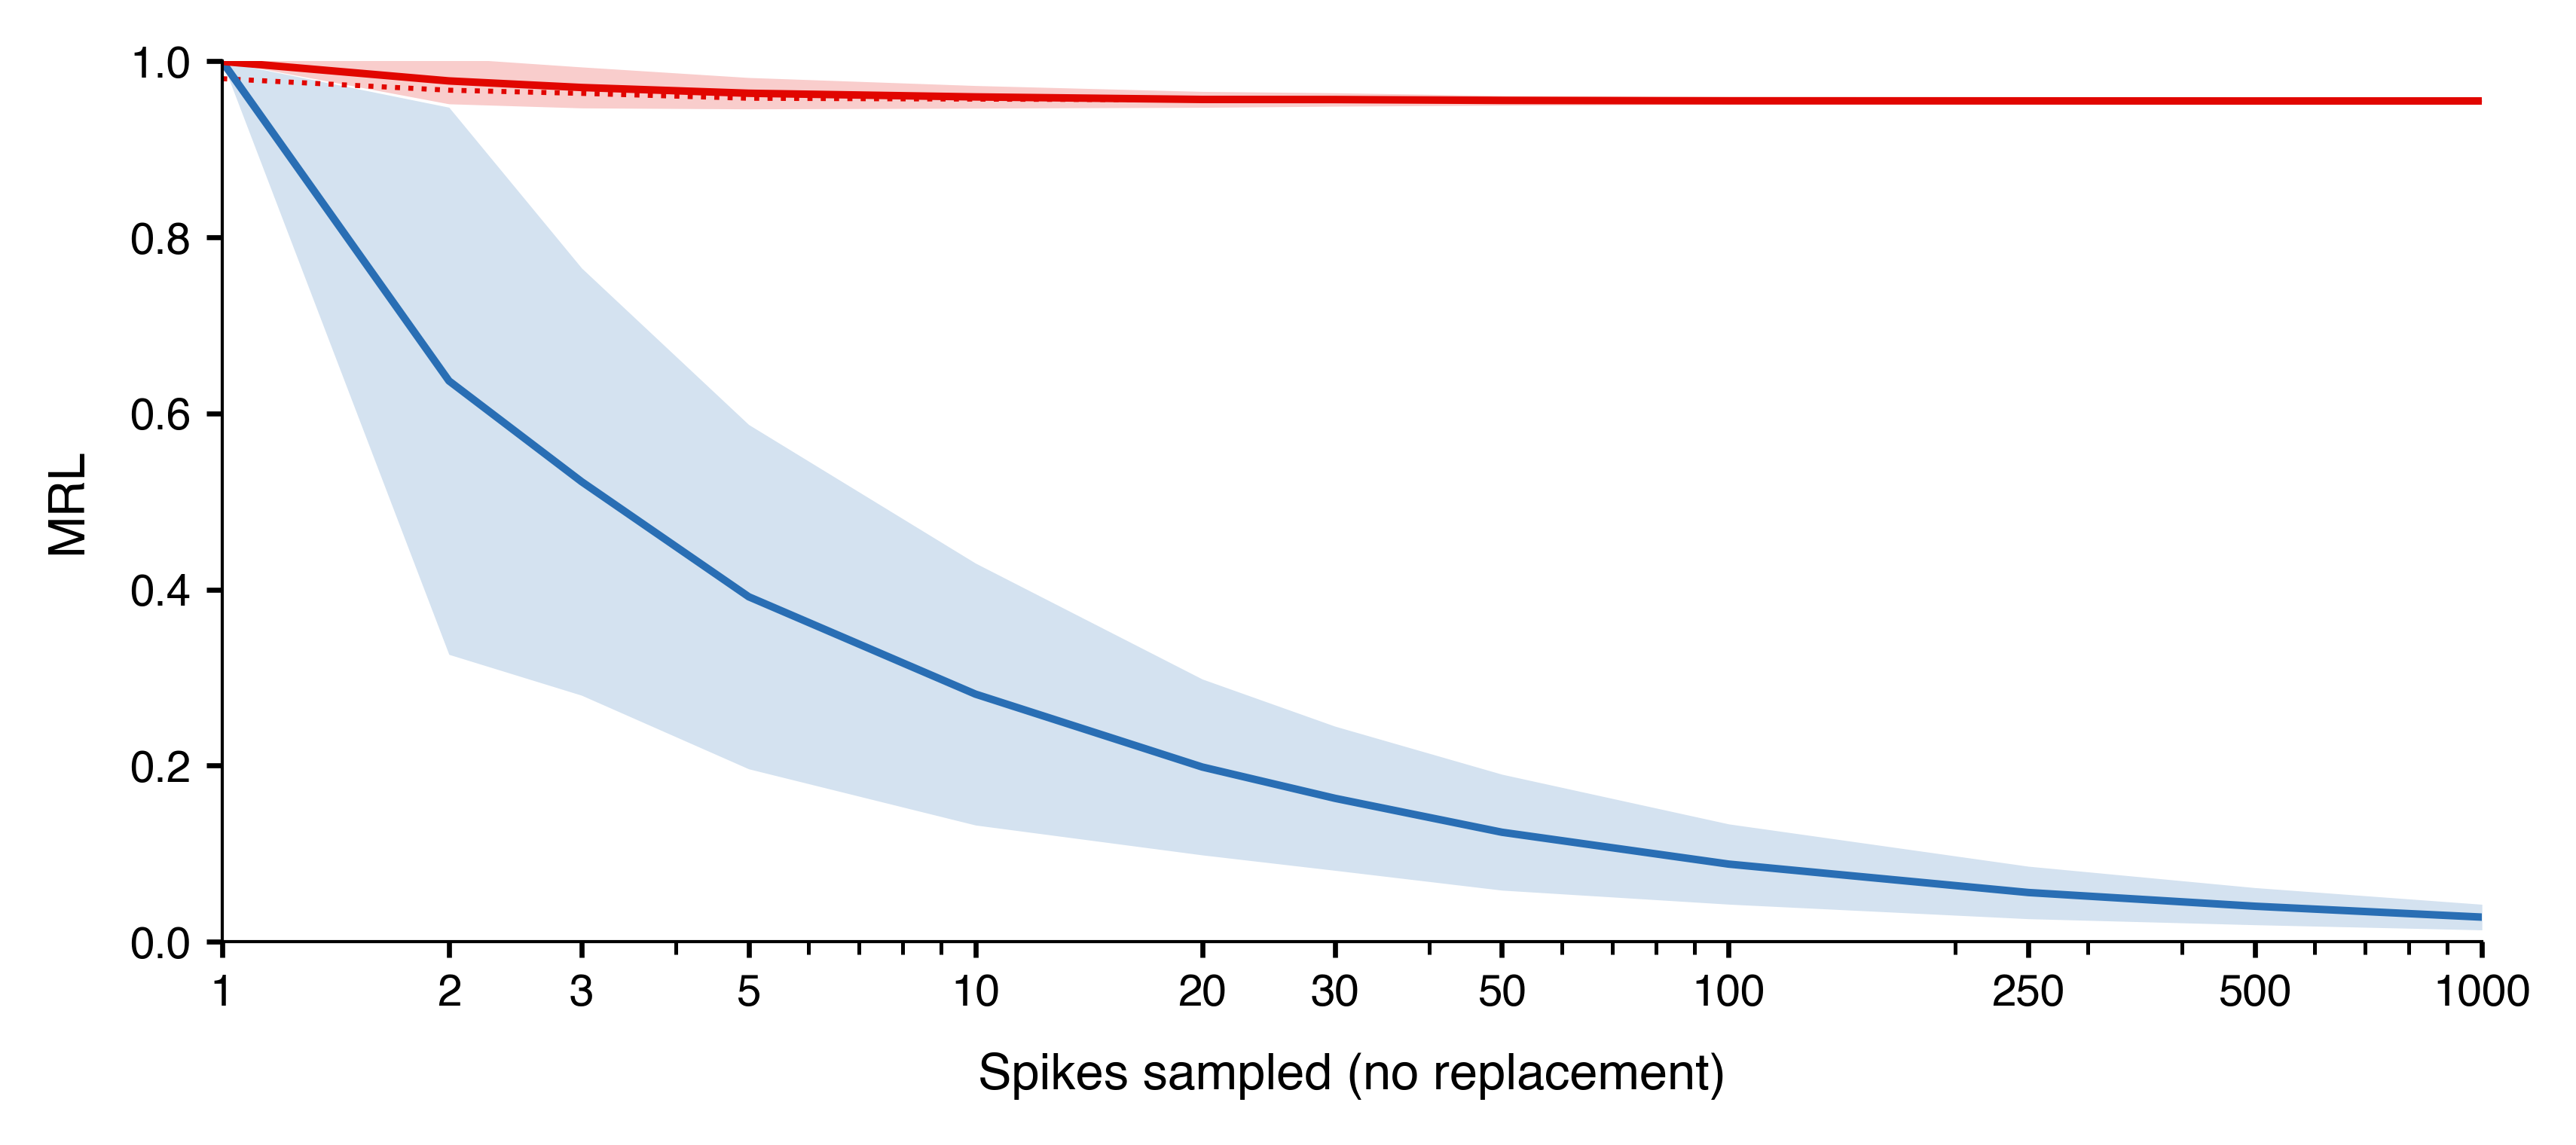

In [171]:
noise_n = [1, 2, 3, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
signal_mult = 2
signal_prop = 0.2
n_samp_iter = 1
n_perm = 1000
lw = 1.2

timer = Timer()

mrls1 = []
mrls2 = []
for ii in range(n_perm):
    v1 = [np.random.uniform(-np.pi, np.pi, size)
          for size in noise_n]
    v2 = [np.concatenate((np.random.uniform(-np.pi, np.pi, int(size * signal_mult * (1-signal_prop))),
                          np.random.uniform(0, np.pi/3, (size * signal_mult) - int(size * signal_mult * (1-signal_prop)))))
          for size in noise_n]
    mrls1.append([circstats.circmoment(v1[iSize])[1]
                  for iSize in range(len(noise_n))])
    mrls2.append(np.nanmean([[circstats.circmoment(np.random.choice(v2[iSize], noise_n[iSize], replace=False))[1]
                              for iSize in range(len(noise_n))]
                             for ii in range(n_samp_iter)], axis=0))
mrls1 = np.array(mrls1)
mrls2 = np.array(mrls2)

plt.close()
fig, ax = plt.subplots(1, 1)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]

xvals = sizes

# Plot MRL for all spikes from the signal vector.
_ax.plot(xvals,
         [np.mean([circstats.circmoment(np.concatenate((np.random.uniform(-np.pi, np.pi, int(size * signal_mult * (1-signal_prop))),
                                                        np.random.uniform(0, np.pi/3, (size * signal_mult) - int(size * signal_mult * (1-signal_prop))))))[1]
                   for _ in range(100)])
          for size in noise_n], lw=0.8, ls='dotted', color=colors['r'])

# Plot noise by no. spikes.
_means = np.nanmean(mrls1, axis=0)
_stds = np.nanstd(mrls1, axis=0)
_ax.fill_between(xvals, _means + _stds, _means - _stds, lw=0, color=colors['b'], alpha=0.2)
_ax.plot(xvals, _means, lw=lw, color=colors['b'])

# Plot signal by no. spikes sampled.
_means = np.nanmean(mrls2, axis=0)
_stds = np.nanstd(mrls2, axis=0)
_ax.fill_between(xvals, _means + _stds, _means - _stds, lw=0, color=colors['r'], alpha=0.2)
_ax.plot(xvals, _means, lw=lw, color=colors['r'])

_ax.set_xscale('log')
_ax.set_xlim([1, 1000])
_ax.set_xticks(xvals)
_ax.set_xticklabels(xvals)
_ax.set_xlabel('Spikes sampled (no replacement)')
_ax.set_ylim([0, 1])
_ax.set_yticks(np.linspace(0, 1, 6))
_ax.set_ylabel('MRL')

print('noise_n: {}'.format(noise_n),
      'signal_mult: {}'.format(signal_mult),
      'signal_prop: {}'.format(signal_prop),
      'n_samp_iter = {}'.format(n_samp_iter),
      'n_perm: {}'.format(n_perm),
      sep='\n')
print(timer)

fig.show()

noise_n: 10
signal_n: 80
signal_prop: 0.2
n_samp_iter = 10
n_perm: 1000


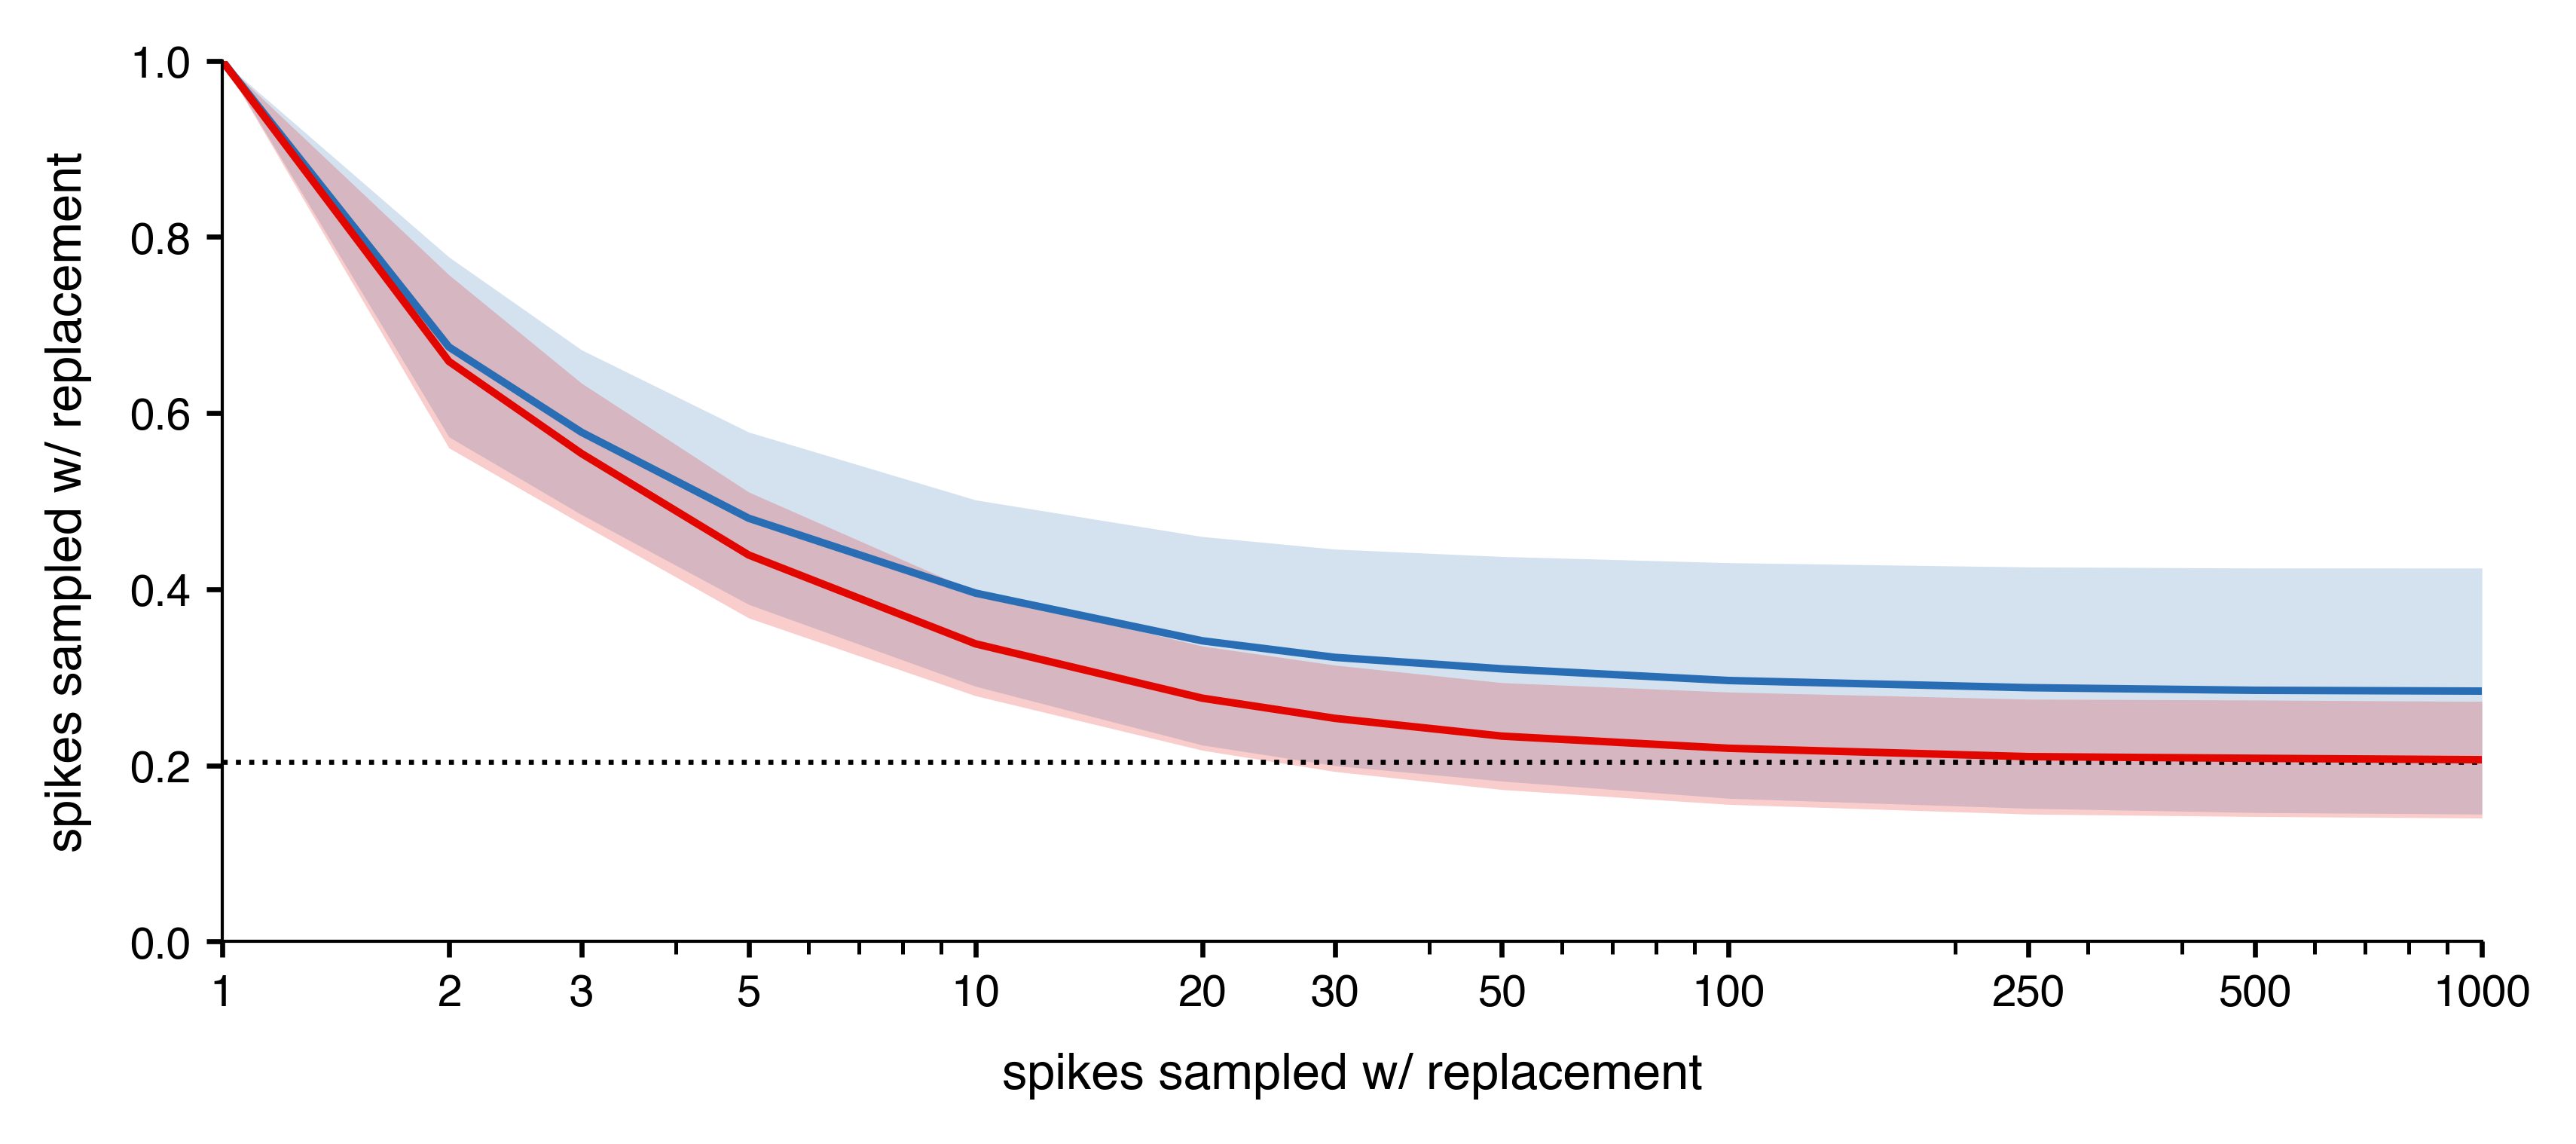

In [114]:
noise_n = 30
signal_n = 80
signal_prop = 0.2
n_samp_iter = 10
n_perm = 1000

mrls1 = []
mrls2 = []
for ii in range(n_perm):
    v1 = np.random.uniform(-np.pi, np.pi, noise_n)
    v2 = np.concatenate((np.random.uniform(-np.pi, np.pi, int(signal_n * (1-signal_prop))),
                         np.random.uniform(0, np.pi/3, int(signal_n * signal_prop))))
    mrls1.append([np.nanmean([circstats.circmoment(np.random.choice(v1, size=size, replace=True))[1]
                              for _ in range(n_samp_iter)])
                  for size in sizes])
    mrls2.append([np.nanmean([circstats.circmoment(np.random.choice(v2, size=size, replace=True))[1]
                              for _ in range(n_samp_iter)])
                  for size in sizes])
mrls1 = np.array(mrls1)
mrls2 = np.array(mrls2)

plt.close()
fig, ax = plt.subplots(1, 1)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]

xvals = sizes

# Plot true MRL.
_ax.axhline(np.mean([circstats.circmoment(np.concatenate((np.random.uniform(-np.pi, np.pi, int(signal_n * (1-signal_prop))),
                                                          np.random.uniform(0, np.pi/3, int(signal_n * signal_prop)))))[1]
                     for _ in range(1000)]), lw=0.8, ls='dotted', color='k')

# Plot noise.
_means = np.nanmean(mrls1, axis=0)
_stds = np.nanstd(mrls1, axis=0)
_ax.fill_between(xvals, _means + _stds, _means - _stds, lw=0, color=colors['b'], alpha=0.2)
_ax.plot(xvals, _means, lw=1.2, color=colors['b'])

# Plot signal.
_means = np.nanmean(mrls2, axis=0)
_stds = np.nanstd(mrls2, axis=0)
_ax.fill_between(xvals, _means + _stds, _means - _stds, lw=0, color=colors['r'], alpha=0.2)
_ax.plot(xvals, _means, lw=1.2, color=colors['r'])

_ax.set_xscale('log')
_ax.set_xlim([1, 1000])
_ax.set_xticks(xvals)
_ax.set_xticklabels(xvals)
_ax.set_xlabel('spikes sampled w/ replacement')
_ax.set_ylim([0, 1])
_ax.set_yticks(np.linspace(0, 1, 6))
_ax.set_ylabel('MRL')

print('noise_n: {}'.format(noise_n),
      'signal_n: {}'.format(signal_n),
      'signal_prop: {}'.format(signal_prop),
      'n_samp_iter = {}'.format(n_samp_iter),
      'n_perm: {}'.format(n_perm),
      sep='\n')

fig.show()

In [174]:
# Find the minimum number of spikes at each channel and frequency,
# between dug and not dug golds.
samp_spikes = np.nanmin([[[spike_phases[key][iChan, iFreq, :].compressed().size
                           for iFreq in range(n_freq)]
                          for iChan in range(n_chan)]
                         for key in gold_keys], axis=0)  # [chan, freq]

In [204]:
timer = Timer()

# Calculate mean resultant lengths for each channel and frequency.
n_freq = phase.freq.size
n_chan = phase.chan.size
mrls = {key: np.empty([n_chan, n_freq], dtype=np.float32)
        for key in gold_keys}
for key in gold_keys:
    for iChan in range(n_chan):
        _mrls = []
        for iFreq in range(n_freq):
            phi = spike_phases[key][iChan, iFreq, :].compressed()
            if samp_spikes[iChan, iFreq] < 2:
                mrls[key][iChan, iFreq] = np.nan
            elif phi.size == samp_spikes[iChan, iFreq]:
                mrls[key][iChan, iFreq] = circstats.circmoment(phi)[1]
            else:
                mrls[key][iChan, iFreq] = np.nanmean(
                    [circstats.circmoment(np.random.choice(phi,
                                                           size=samp_spikes[iChan, iFreq],
                                                           replace=False))[1]
                     for _ in range(n_samp_iter)]
                )
mrls = {key: np.nanmean(mrls[key], axis=0)
        for key in gold_keys}  # [gold_key][freq]
                
print(timer)

Ran in 0.1s


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
